In [1]:
import tensorflow as tf
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import os
import cv2
import numpy as np
from random import random, randint, choices
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, AveragePooling2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model


In [2]:
# generated CAPTCHAs using Python ImageCaptcha Library
alphabet_all = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
#alphabet_all = list('qwertyupasdfghjkzxcvbnmo23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
num_alphabet = len(alphabet)

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135
# Non-configs
PATH = os.getcwd() # get current path
DATA_PATH = os.path.join(PATH, 'train')# create new folder for data

In [4]:
print(PATH)

c:\Users\Simon\Desktop\Code\TextCaptchaPR\Captcha


In [5]:
# Save model and weights
def SaveModel(model, save_dir, model_name):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % save_dir)

In [6]:
#pre-processing
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabet.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1
                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [7]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 50*1000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

# Frequency check


The frequency of alphanumer characters was tested here. The code for these tests and its output is shown in DataExploration.ipynb.

# Continuing with Model creation

In [8]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 50000 (train=44942, test=5058)


In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(44942, 25, 67, 1)
(44942, 5, 62)
(5058, 25, 67, 1)
(5058, 5, 62)


In [10]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [11]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = ''

In [12]:
def ModelVGG19(input_shape):
    input_layer = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)  
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

      
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_VGG19_trained_model.h5'

    return model


In [13]:
#architecture
def ModelCifar10(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_Cifar10_trained_model.h5'
    return model


    

In [14]:
#LeNet-5 architecture
def ModelLeNet(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=6, kernel_size=(5, 5), activation='tanh')(input_layer)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    x = Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh')(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(120, activation='tanh')(x)
    x = Dense(84, activation='tanh')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    
    model = Model(inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_name = 'keras_LeNet_trained_model.h5'
    return model




In [15]:
#Wang et al. DenseNet model DFCR ------ https://www.aimspress.com/article/doi/10.3934/mbe.2019292?viewType=HTML || CAPTCHA recognition based on deep convolutional neural network

def modelDFCR(input_shape):
    """
    Architecture DFCR in paper is set up as follows:
    1. Original Captcha images with a size of 224x224 are convoluted and pooled to output the cropped Captcha images with a size of 56x56
    2. Then 4 dense blocks are concatenated in turn, with a transition block inbetween each dense block

    A dense block consists of a bottleneck layer, non-linear ReLU, a conv(1x1), a second bottleneck layer, non-linear ReLu and conv(3x3)
    A transition layer consists of a bottleneck layer, conv(1x1) and averagePool(2x2)
    
    """
    
    input_layer = Input(input_shape)
    #first step
    x = Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', strides=2)(input_layer)
    x = MaxPooling2D(pool_size=(3, 3),strides=(2, 2))(x)

    #first dense block
    # x = bottleneck layer
    


    #first transition layer
    #???


In [16]:
# Zhong Wang CAPTCHA Recognition Method Based on CNN with Focal Loss || https://downloads.hindawi.com/journals/complexity/2021/6641329.pdf

def Model_WangComplex(input_shape):
    """"
    input - conv1 - PreLu - Pool_1 - Conv2- PreLu2 - Pool_2 - Conv_3 - PReLU_3 - Pool_3 - Fc_1 - Cls_prob - loss function - Bbox_pred - loss function
    
    """
    # input layer
    input_layer = Input(input_shape)

    # Conv_1
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    
    #Conv_2
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    #Pooling P3
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_4
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_5
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    #Pooling P6
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_7
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_8
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Pooling 9
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_10
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_11
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Poolin 12
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Flattening 13
    x = Flatten()(x)

    #Dense
    x = Dense(120, activation='sigmoid')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='sigmoid')(x) for i in range(NUM_OF_LETTERS)]
    
    model = Model(inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_name = 'keras_trained_model_WangComplex.h5'
    return model


In [17]:
# model = ModelCifar10((25, 67, 1))
# model = ModelVGG19((25, 67, 1))
model_name = 'keras_LeNet_trained_model.h5'
model = ModelLeNet((25, 67, 1))


In [31]:
model_name = 'keras_trained_model_WangComplex.h5'
model = Model_WangComplex((25, 67, 1))

In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25, 67, 1)]  0           []                               
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 25, 67, 32)   320         ['input_3[0][0]']                
__________________________________________________________________________________________________
batch_normalization_8 (BatchNo  (None, 25, 67, 32)   128         ['conv2d_10[0][0]']              
rmalization)                                                                                      
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 25, 67, 32)   9248        ['batch_normalization_8[0][

In [20]:
# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [21]:
# # initiate Adam optimizer

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])


# model.summary() 

In [33]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [34]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test), 
                    callbacks=[callback]
                   )

Epoch 1/50
352/352 [==============================] - 252s 708ms/step - loss: 15.2147 - digit0_loss: 2.8791 - digit1_loss: 3.1983 - digit2_loss: 3.1961 - digit3_loss: 3.1429 - digit4_loss: 2.7983 - digit0_accuracy: 0.2826 - digit1_accuracy: 0.1709 - digit2_accuracy: 0.1672 - digit3_accuracy: 0.1903 - digit4_accuracy: 0.3034 - val_loss: 21.8911 - val_digit0_loss: 5.3620 - val_digit1_loss: 4.2935 - val_digit2_loss: 4.0487 - val_digit3_loss: 4.1750 - val_digit4_loss: 4.0120 - val_digit0_accuracy: 0.0354 - val_digit1_accuracy: 0.0285 - val_digit2_accuracy: 0.0277 - val_digit3_accuracy: 0.0289 - val_digit4_accuracy: 0.0358
Epoch 2/50
352/352 [==============================] - 246s 699ms/step - loss: 8.0563 - digit0_loss: 1.1846 - digit1_loss: 1.9022 - digit2_loss: 2.0003 - digit3_loss: 1.8098 - digit4_loss: 1.1594 - digit0_accuracy: 0.7946 - digit1_accuracy: 0.5861 - digit2_accuracy: 0.5398 - digit3_accuracy: 0.6087 - digit4_accuracy: 0.7962 - val_loss: 7.2181 - val_digit0_loss: 1.1262 - va

In [36]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

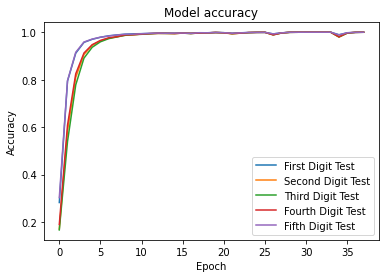

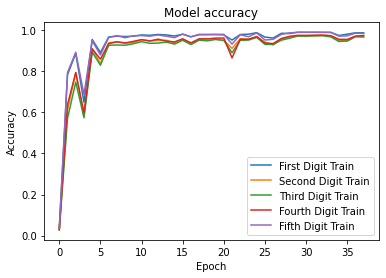

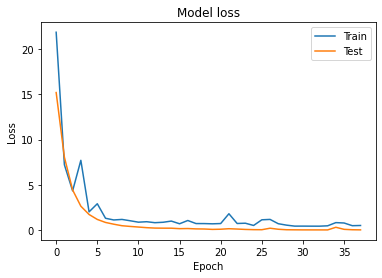

In [37]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [38]:
save_dir = os.path.join(PATH, 'saved_models')
SaveModel(model, save_dir, model_name)

Saved trained model at c:\Users\Simon\Desktop\Code\TextCaptchaPR\Captcha\saved_models 


In [39]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))


1405/1405 [==============================] - 58s 41ms/step - loss: 0.0203 - digit0_loss: 0.0036 - digit1_loss: 0.0041 - digit2_loss: 0.0034 - digit3_loss: 0.0032 - digit4_loss: 0.0060 - digit0_accuracy: 0.9992 - digit1_accuracy: 0.9993 - digit2_accuracy: 0.9996 - digit3_accuracy: 0.9996 - digit4_accuracy: 0.9983
Train loss:     0.006946
Train accuracy: 99.60


In [40]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

159/159 [==============================] - 6s 40ms/step - loss: 0.4967 - digit0_loss: 0.0468 - digit1_loss: 0.1264 - digit2_loss: 0.1311 - digit3_loss: 0.1173 - digit4_loss: 0.0751 - digit0_accuracy: 0.9868 - digit1_accuracy: 0.9705 - digit2_accuracy: 0.9660 - digit3_accuracy: 0.9729 - digit4_accuracy: 0.9830
Test loss:     0.183680
Test accuracy: 88.48
